In [1]:
cd ..

/data/a/cpac/isultan/projects/halomassloss/core_catalog_mevolved


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import subhalo_mass_loss_model as SHMLM
import genericio as gio
from itk import hist, h5_read_dict, gio_read_dict, loadpickle, plt_latex
from plot_subhalo_mass_fn import CMF, SHMF, plotCMF, plotSHMF

In [3]:
plt_latex()

In [4]:
# Load 2016b Figure 5 plots
fig5a = loadpickle("Notebooks/2016b_fig5a.p") #[12,12.5]
fig5b = loadpickle("Notebooks/2016b_fig5b.p") #[13,13.5]
fig5c = loadpickle("Notebooks/2016b_fig5c.p") #[14,14.5]
fig5 = {12:fig5a, 13:fig5b, 14:fig5c}

In [5]:
def fig5_plot(M1):
    """Plot 2016B Figure 5 plot of M range [M1, M1+0.5]."""
    plotsd = fig5[np.log10(M1)]
    for k in plotsd.keys():
        plt.plot(plotsd[k][:,0][np.argsort(plotsd[k][:,1])], plotsd[k][:,1][np.argsort(plotsd[k][:,1])], '-', label=k, alpha=0.7)

/home/isultan/projects/itk/itk.py:75: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)
/home/isultan/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


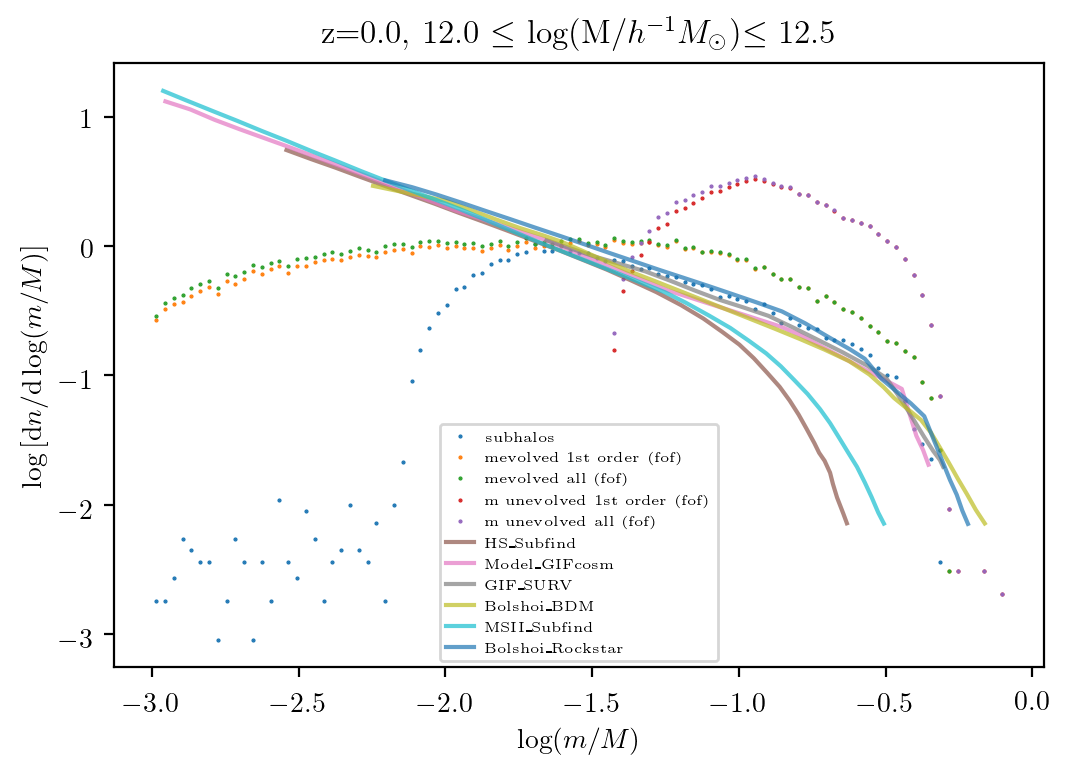

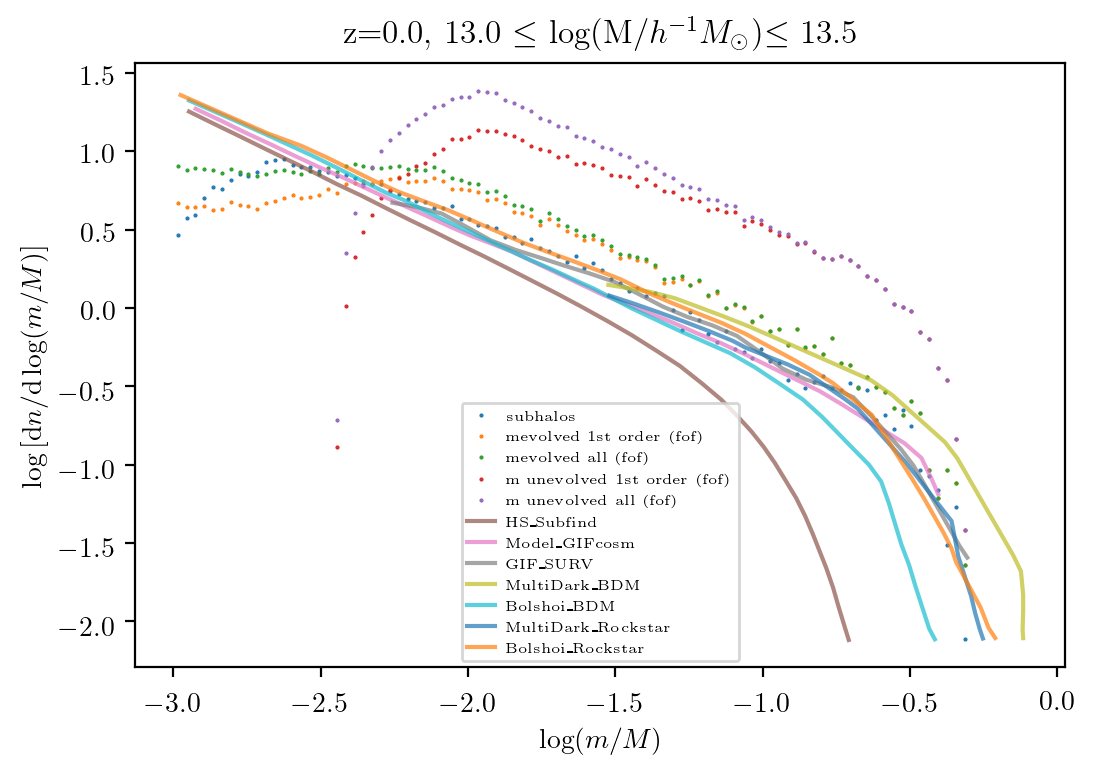

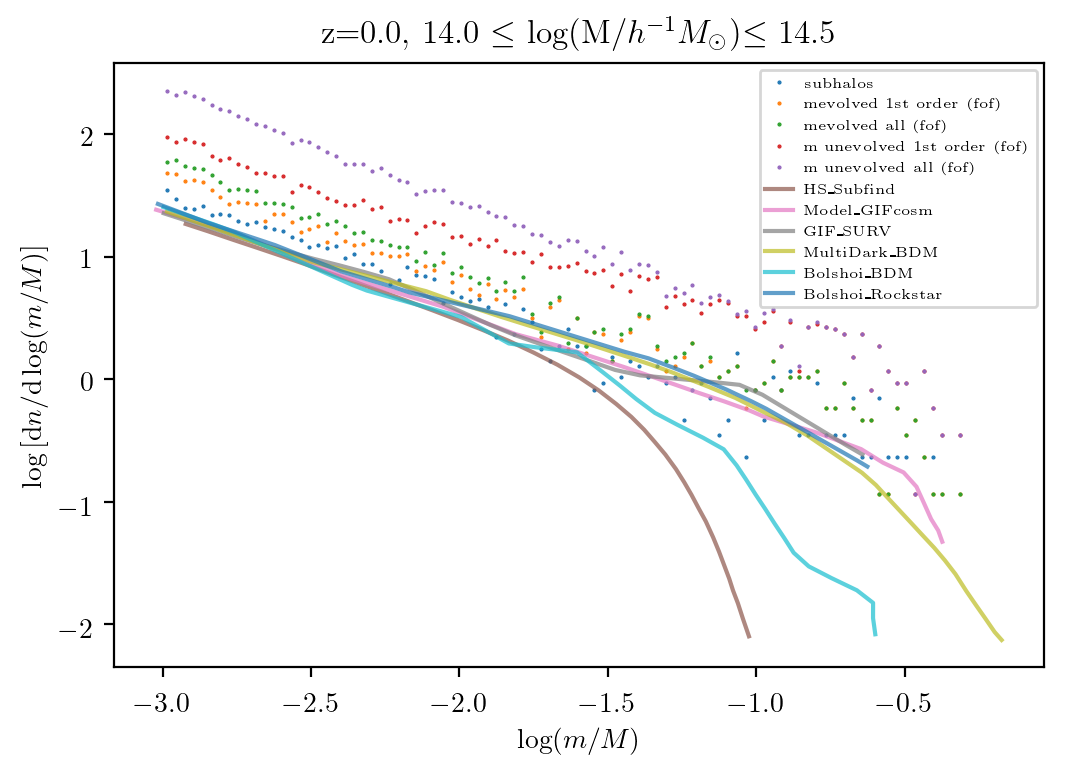

In [6]:
step=499
rall = {12:-4,13:-5,14:-6}
for M1 in [12.,13.,14.]:
#     r = (rall[M1], 0)
    r = (-3,0)
    
    M2 = M1 + 0.5
    M1 = 10**M1
    M2 = 10**M2

    plt.figure(dpi=200)
    plotSHMF(M1, M2, r)
    
#     plotCMF('output_merg_virial/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, returnUnevolved=False, label='mevolved 1st order (virial)', r=r)
#     plotCMF('output_merg_virial/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=False, returnUnevolved=False, label='mevolved all (virial)', r=r)
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, returnUnevolved=False, label='mevolved 1st order (fof)', r=r)
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=False, returnUnevolved=False, label='mevolved all (fof)', r=r)
    
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, returnUnevolved=True, label='m unevolved 1st order (fof)', r=r)
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=False, returnUnevolved=True, label='m unevolved all (fof)', r=r)

    fig5_plot(M1)

    plt.xlabel(r'$\log(m/M)$')
    plt.ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
    plt.title( 'z=' + str(round(SHMLM.step2z[step],3)) + r', {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) );
    plt.legend(prop={'size': 5})